In [1]:
from cpymad.madx import Madx

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import stats
from scipy.optimize import least_squares as ls

# standard configurations
get_ipython().magic('matplotlib inline')
%config InlineBackend.figure_format = 'retina' # retina display


def plotLatticeSeries(ax, series, height=1., v_offset=0., color='r',alpha=0.5,lw=1):
    aux=series
    ax.add_patch(
    patches.Rectangle(
        (aux.s-aux.l, v_offset-height/2.),   # (x,y)
        aux.l,          # width
        height,          # height
        color=color, alpha=alpha,lw=lw
    )
    )
    return;

In [38]:
madx = Madx(stdout=False)

pc = np.sqrt(2*0.9382720813*50*10**(-6)) # Kin Energy 50 KeV


def input_str(x):
    return '''
    
    CALL, FILE = "Optics_v7.str";
    CALL, FILE = "CRYRING_v7.1.0.seq";

    beam, particle = proton, sequence=cryring, pc = {};
    use, sequence=cryring;

    select, flag=twiss, column=apertype, aper_1, aper_2;
    twiss;
    '''.format(x)


MyString = input_str(pc)

madx.input(MyString);

In [3]:
kh1 = np.random.normal(0,0.001)
kh2 = np.random.normal(0,0.001)
kh3 = np.random.normal(0,0.001)
print(f"{kh1} {kh2} {kh3}")

madx.input('k02kh = {};k08kh ={};k10kh ={};twiss;'.format(kh1,kh2,kh3))
DF=madx.table.twiss.dframe()
bpmDF = DF[DF["keyword"]=="hmonitor"]
xbpm =DF[DF["keyword"]=="hmonitor"]["x"]+np.random.normal(0,0.005,len(bpmDF))

kicker1 = DF[DF["name"].str.contains('02kh')]
kicker2 = DF[DF["name"].str.contains('08kh')]
kicker3 = DF[DF["name"].str.contains('10kh')]



-0.00014890170496784392 -0.0003386601397413293 -0.0006782098026831211


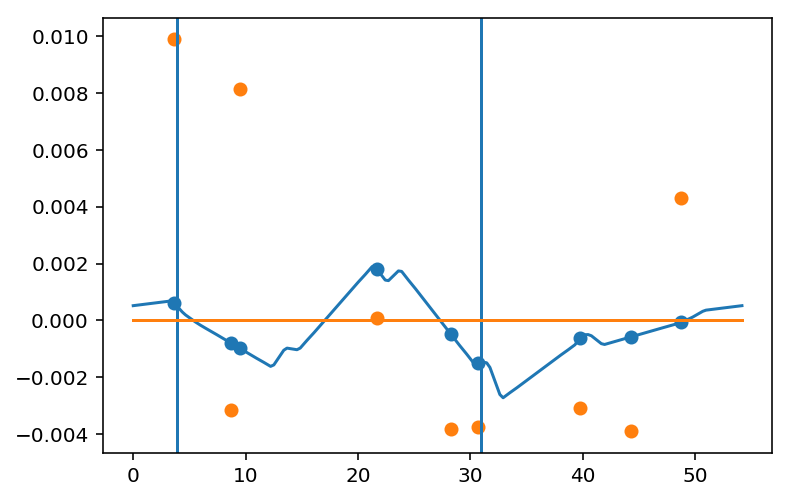

In [4]:
plt.plot(DF.s,DF.x)
plt.scatter(bpmDF.s,bpmDF.x)
plt.scatter(bpmDF.s,xbpm)
plt.axvline(kicker1.s[0])
plt.axvline(kicker2.s[0])


plt.plot(DF.s,DF.y)
plt.show()

In [5]:
kf0=0.5086546699
kd0 =-0.6511149282
kqfl = np.linspace(kf0-kf0/100,kf0+kf0/100,20)
kqdl = np.linspace(kd0-kd0/100,kd0+kd0/100,20)

orbit1,bpm1 = [],[]
for x in kqfl:
    madx.input('kqfl = {};twiss;'.format(x))
    aux=madx.table.twiss.dframe()
    bpm1.append(aux[aux["keyword"]=="hmonitor"])
    orbit1.append(aux)
    
orbit2,bpm2 = [],[]
for x in kqdl:
    madx.input('kqdl = {};twiss;'.format(x))
    aux=madx.table.twiss.dframe()
    bpm2.append(aux[aux["keyword"]=="hmonitor"])
    orbit2.append(aux)



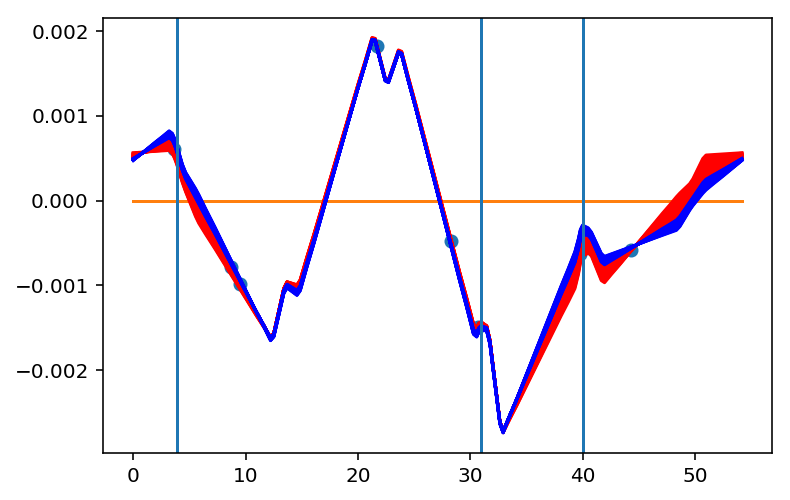

In [6]:
plt.plot(DF.s,DF.x)
plt.plot(DF.s,DF.y)
plt.scatter(bpmDF.s,bpmDF.x)

[plt.plot(a.s,a.x, color = "red") for a in orbit1]
[plt.plot(a.s,a.x, color = "blue") for a in orbit2]

plt.axvline(kicker1.s[0])
plt.axvline(kicker2.s[0])
plt.axvline(kicker3.s[0])


plt.show()

In [7]:
print(f"{kh1} {kh2} {kh3}")


-0.00014890170496784392 -0.0003386601397413293 -0.0006782098026831211


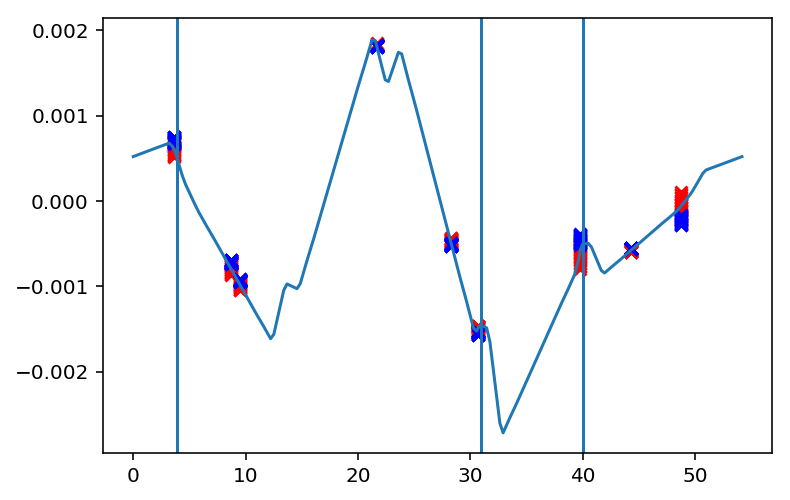

In [8]:
plt.plot(DF.s,DF.x)

[plt.scatter(a.s,a.x, color = "red", marker ="x") for a in bpm1]
[plt.scatter(a.s,a.x, color = "blue", marker ="x") for a in bpm2]

plt.axvline(kicker1.s[0])
plt.axvline(kicker2.s[0])
plt.axvline(kicker3.s[0])

plt.show()

In [9]:
tmp=[np.array(a["x"]) for a in bpm1]
aux =np.transpose(tmp)
vec =[np.max(x)-np.min(x) for x in aux]

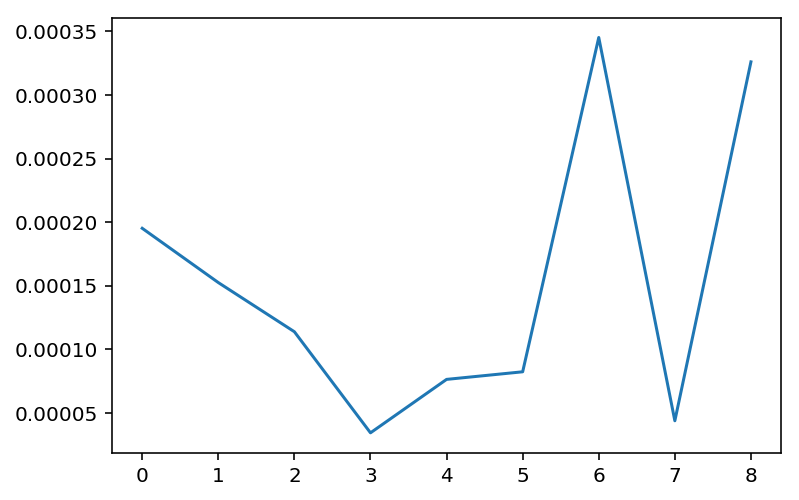

In [10]:
plt.plot(vec)

In [68]:
kf0=0.5086546699
kd0 =-0.6511149282
kqfl = np.linspace(kf0-2*kf0/100,kf0+2*kf0/100,3)
kqdl = np.linspace(kd0-2*kd0/100,kd0+2*kd0/100,3)

offset =np.random.normal(0,0.001,9) # offset of bpm reading

def func(theta):
    madx.input('k02kh = {};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k01kh = {};twiss;'.format(*theta))


    bpm = []
    for x in kqfl:
        madx.input('kqfl = {};twiss;'.format(x))
        aux=madx.table.twiss.dframe()
        xbpm = aux[aux["keyword"]=="hmonitor"]["x"]+offset
        bpm.append(xbpm)

    for x in kqdl:
        madx.input('kqdl = {};twiss;'.format(x))
        aux=madx.table.twiss.dframe()
        xbpm = aux[aux["keyword"]=="hmonitor"]["x"]+offset
        bpm.append(xbpm)

        
#    tmp=[np.array(a["x"]) for a in bpm]
    aux =np.transpose(bpm)
    metric = [np.max(x)-np.min(x) for x in aux]
    print('metric = {}'.format(np.mean(metric)))
    return metric

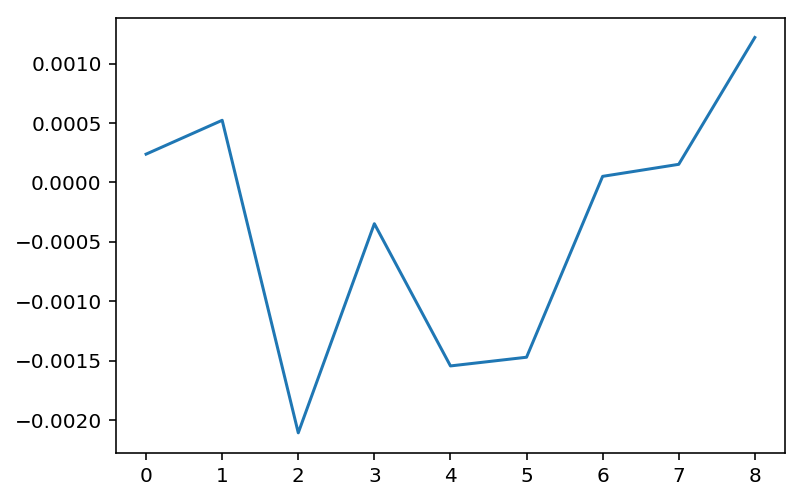

In [12]:
plt.plot(offset)

In [49]:
theta0 = [np.random.normal(0,0.001) for i in range(6)]
aux = func(theta0)

DF0=madx.table.twiss.dframe()
bpmDF0 = DF0[DF0["keyword"]=="hmonitor"]
xbpm0 = bpmDF0["x"]+offset

In [14]:
vec =ls(func, theta0)
vec.x

array([ 2.35848232e-08,  2.75897434e-09, -4.24387281e-08, -7.40169725e-08,
       -5.23644096e-08,  7.46858494e-04])

In [15]:
madx.input('kqfl ={}; kqdl ={}; k02kh = {};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k01kh = {};twiss;'.format(kf0,kd0,*vec.x));
print(f'Q1 = {madx.table.summ.q1[0]:1.6}')
print(f'Q2 = {madx.table.summ.q2[0]:1.6}')
DF=madx.table.twiss.dframe()
bpmDF = DF[DF["keyword"]=="hmonitor"]
xbpm = bpmDF["x"]+offset

quadDF = DF[DF["keyword"]=="quadrupole"]

Q1 = 2.42
Q2 = 2.42


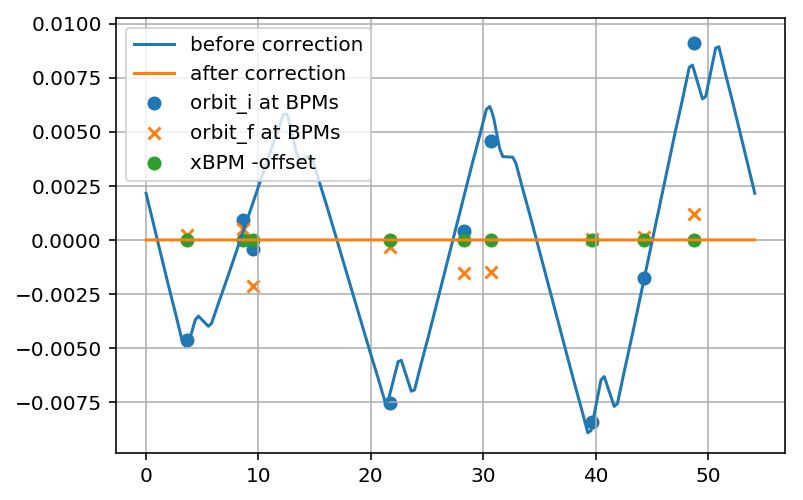

In [16]:
plt.plot(DF0.s,DF0.x, label = "before correction")
plt.scatter(bpmDF0.s,xbpm0, label = "orbit_i at BPMs")

plt.plot(DF.s,DF.x, label = "after correction")
plt.scatter(bpmDF.s,xbpm, marker = "x", label = "orbit_f at BPMs")

plt.scatter(bpmDF.s,xbpm-offset, label = "xBPM -offset")
#plt.plot(bpmDF.s,offset, label = "offset")


#plt.scatter(quadDF.s,quadDF.x)
#plt.plot(DF.s,DF.y)
plt.legend()
plt.grid(True)
plt.show()

In [80]:
def metric_counter(theta):

    madx.input('k02kh ={};twiss;'.format(theta));

    DF0=madx.table.twiss.dframe()
    xbpm0 =DF0[DF0["keyword"]=="hmonitor"]["x"]

    delta = 2*kf0/100
    kf = kf0+delta
    kd = kd0+delta
    madx.input('kqfl = {};kqdl = {};twiss;'.format(kf,kd0))
    aux=madx.table.twiss.dframe()
    xbpm = aux[aux["keyword"]=="hmonitor"]["x"]
    df1 = np.array(xbpm-xbpm0)/delta
#    df1 = np.array(xbpm-xbpm0)
    
    madx.input('kqfl = {};kqdl = {};twiss;'.format(kf0,kd))
    aux=madx.table.twiss.dframe()
    xbpm = aux[aux["keyword"]=="hmonitor"]["x"]
#    df2 = np.array(xbpm-xbpm0)/delta
    df2 = np.array(xbpm)
    
#    print(df1[0]+df2[0])
#    return df1[0],df2[0] 
    return df1,df2


In [58]:
madx.input('kqfl ={}; kqdl ={}; k02kh = {};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k01kh = {};twiss;'.format(kf0,kd0,*theta0));

theta = np.linspace(-0.001,0.001,30)
aux = [metric_counter(th) for th in theta]
aux1=[a[0] for a in aux]
aux2=np.array([a[1] for a in aux])

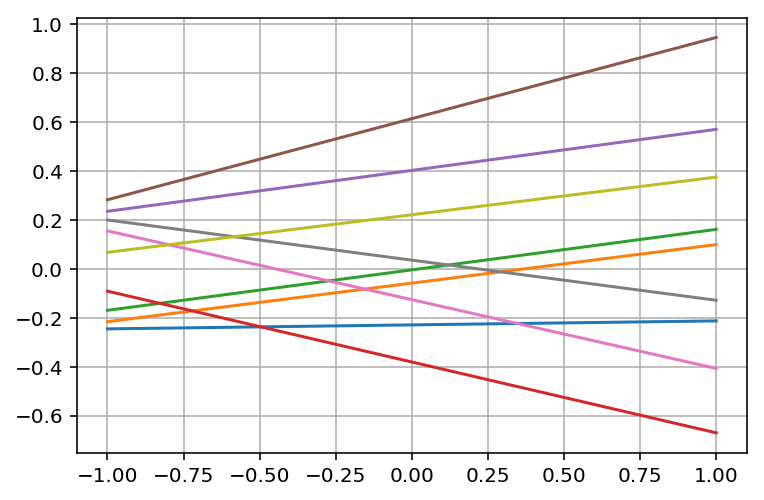

In [60]:
plt.plot(1000*theta,aux1)
#plt.plot(1000*theta,100*aux2)

plt.grid(True)

In [15]:
# ! extend to dx/dkd !!
def find_gradient(theta):
    
    kf0=0.5086546699
    kd0 =-0.6511149282
    
    delta = 2*kf0/100
    k = kf0+delta

    madx.input('''kqfl ={}; kqdl ={}; 
    k02kh = {};k03kh1 ={};k03kh2={};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k01kh ={};k01lb={};
    twiss;'''.format(kf0,kd0,*theta));

    aux=madx.table.twiss.dframe()
    xbpm0 =aux[aux["keyword"]=="hmonitor"]["x"]

    madx.input('''kqfl ={}; kqdl ={}; 
    k02kh = {};k03kh1 ={};k03kh2={};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k01kh ={};k01lb={};
    twiss;'''.format(k,kd0,*theta));

    aux=madx.table.twiss.dframe()
    xbpm = aux[aux["keyword"]=="hmonitor"]["x"]

    return np.array(xbpm-xbpm0)/delta


# theta is initial non-zero vector for the ideal case, basically theta != theta*
theta0 = np.random.normal(0,0.001,9)
print(theta0)

# find zero dx/dkf gradient (theta = theta0) 
g0 = find_gradient(theta0)


d_theta = np.std(theta0)
print(d_theta)

corr = theta0[:]
grad = []
for i in range(len(theta0)):
    corr[i] += d_theta
    grad.append(find_gradient(corr))
    
    
Jac =np.transpose([(g-g0)/d_theta for g in grad])

print(Jac)

[ 0.00159369 -0.00012936  0.00067727 -0.00172545 -0.0004451   0.00116154
  0.00035529  0.00076658 -0.00025073]
0.0009351405195507445
[[ -71.97842971 -114.5530245   -91.37734364  -39.45281894  -60.92314219
   -48.03772386  -71.63892404  -71.63892404  -71.63892404]
 [ -16.92363804  -43.12262368  -61.77549002  -73.71380909  -56.98774452
   -60.61390865  -74.82775074  -74.82775074  -74.82775074]
 [  -1.15635258  -18.9784608   -45.89037099  -72.94287738  -47.6214078
   -56.80487798  -64.5383145   -64.5383145   -64.5383145 ]
 [ -23.63910614  -21.88006122   17.43239398   67.93281581   -7.34225235
    44.14624534   18.84223639   18.84223639   18.84223639]
 [  -2.678545      0.60489491    4.12380095    8.11027593   23.81896786
   -15.48500199   16.95869127   16.95869127   16.95869127]
 [  13.17767899   18.77144073    1.44799652  -23.01205162   31.87403093
   -40.22547817   11.0719118    11.0719118    11.0719118 ]
 [ -25.2973802   -51.42802282  -50.09388898  -36.4517283   -62.79595953
   -13.074

In [19]:
goal_gradient = np.zeros(9)
#goal_gradient = np.random.normal(0,0.001,9)
np.linalg.solve(Jac, goal_gradient)

array([-0., -0.,  0.,  0., -0.,  0., -0., -0.,  0.])

In [100]:
madx = Madx(stdout=False)

myStr0 = input_str(pc)

myStr1 = '''
addquaderr(dx_err,dy_err,quadname): macro = {
SELECT, FLAG=error, clear;
eoption, seed=2, add=false;
SELECT, FLAG=error, PATTERN="quadname";

EALIGN, DX:=dx_err, DY:=dy_err;
};'''




dxdy = np.random.normal(0.,0.001, 2*18)
myStr2 = '''

exec, addquaderr({},{},YR02QS1);
exec, addquaderr({},{},YR02QS2);
exec, addquaderr({},{},YR02QS3);

exec, addquaderr({},{},YR04QS1);
exec, addquaderr({},{},YR04QS2);
exec, addquaderr({},{},YR04QS3);

exec, addquaderr({},{},YR06QS1);
exec, addquaderr({},{},YR06QS2);
exec, addquaderr({},{},YR06QS3);

exec, addquaderr({},{},YR08QS1);
exec, addquaderr({},{},YR08QS2);
exec, addquaderr({},{},YR08QS3);

exec, addquaderr({},{},YR10QS1);
exec, addquaderr({},{},YR10QS2);
exec, addquaderr({},{},YR10QS3);

exec, addquaderr({},{},YR12QS1);
exec, addquaderr({},{},YR12QS2);
exec, addquaderr({},{},YR12QS3);

SELECT, FLAG = ERROR, FULL;
ESAVE, FILE = err.txt;

select,flag=interpolate, class=drift, slice=20, range=#s/#e;
select,flag=interpolate, class=quadrupole, slice=8, range=#s/#e;
select,flag=interpolate, class=sbend, slice=10, range=#s/#e;
twiss;
'''.format(*dxdy)

madx.input(myStr0);
madx.input(myStr1);
madx.input(myStr2);
DF0=madx.table.twiss.dframe() # HR stands for High Resolution in the s-direction

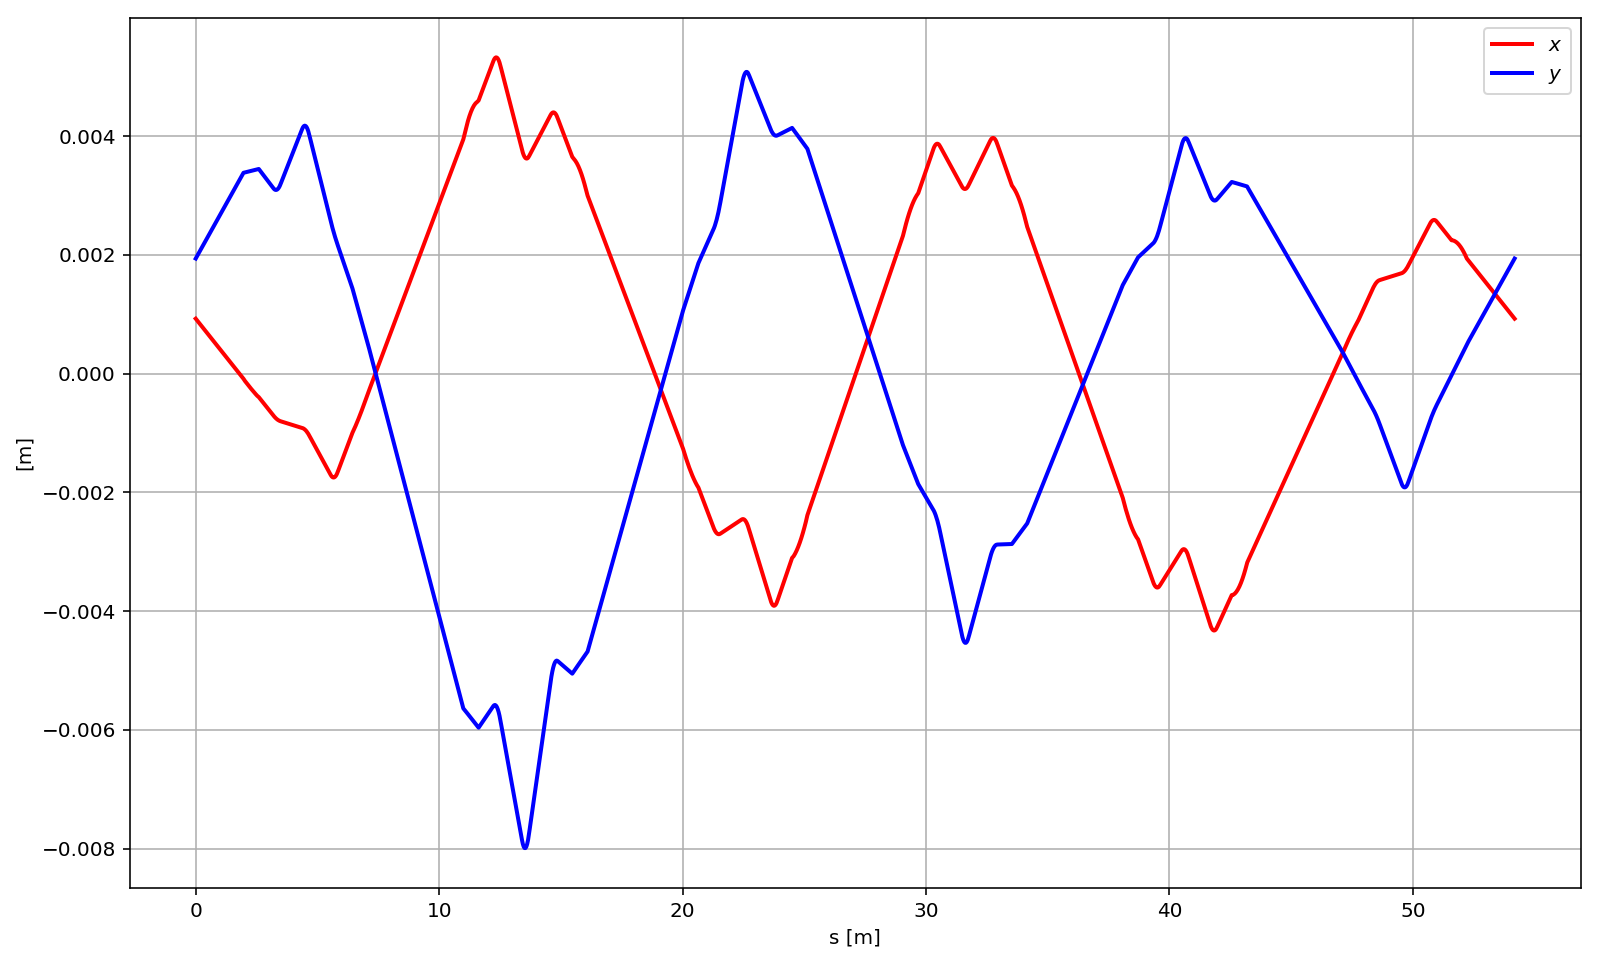

In [101]:
fig = plt.figure(figsize=(13,8))
plt.plot(DF0['s'],DF0['x'],'r', label='$x$', lw=2)
plt.plot(DF0['s'],DF0['y'],'b', label='$y$', lw=2)

plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()

In [109]:
# theta is initial zero vector for the case of the non-ideal lattice, basically theta != theta*
#theta0 = np.random.normal(0,0.001,9)
theta0 = np.zeros(9)
print(theta0)

# find zero dx/dkf gradient (theta = theta0) 
g0 = find_gradient(theta0)

d_theta = np.random.normal(0,0.001)
print(d_theta)

corr = theta0[:]
grad = []
for i in range(len(theta0)):
    corr[i] += d_theta
    grad.append(find_gradient(corr))
    
    
Jac =np.transpose([(g-g0)/d_theta for g in grad])

print(Jac)

[0. 0. 0. 0. 0. 0. 0. 0. 0.]
-0.0005195114862487944
[[ -71.7540614  -113.88061993  -90.4457888   -38.45605811  -60.49059426
   -46.8934484   -70.97075878  -70.97075878  -62.11438134]
 [ -16.60951743  -42.61015374  -61.40334017  -73.61927527  -56.90629394
   -60.25040267  -74.74672938  -74.74672938  -60.07256655]
 [  -0.87073323  -18.58204194  -45.71433786  -73.09649552  -47.64137128
   -56.69891322  -64.61008884  -64.61008884  -52.54998627]
 [ -23.92234729  -22.45690827   17.11392191   68.20444132   -7.50391726
    44.02662265   18.65563152   18.65563152   24.01089349]
 [  -2.56025871    1.07873043    4.90329747    8.85535959   24.26942709
   -14.75679428   17.7921853    17.7921853    -1.62600751]
 [  13.43600523   19.53515744    2.3541997   -22.46049474   32.41437525
   -39.52062732   11.98833718   11.98833718  -13.65322938]
 [ -25.26929809  -51.71910063  -50.65585082  -36.96780373  -63.3196777
   -13.365605    -85.16279208  -85.16279208  -42.7378401 ]
 [  10.06505678   16.91005625   

In [115]:
#goal_gradient = np.zeros(9)
goal_gradient = np.random.normal(0,0.00001,9)

np.linalg.solve(Jac, goal_gradient)

array([ 5.66153388e-05, -2.05694802e-04,  2.63143875e-04, -1.13848688e-04,
        2.50687426e-06, -3.97603010e-07,  2.36945036e+10, -2.36945036e+10,
       -1.50849571e-06])

In [116]:
theta0 = np.random.normal(0,0.001,6)
vec =ls(func, theta0)
vec.x

metric = 0.0007920962912579531
metric = 0.0008890716061169342
metric = 0.0008890824140666299
metric = 0.0008890632410323974
metric = 0.0008890873930532803
metric = 0.0008890660778961505
metric = 0.0008890750440773564
metric = 0.0005412514181143998
metric = 0.0005412555193205575
metric = 0.0005412546818500096
metric = 0.0005412414403342411
metric = 0.0005412605494218375
metric = 0.0005412489563293918
metric = 0.0005412514181143998
metric = 0.0001630936095021471
metric = 0.00016309238452314124
metric = 0.00016309508386542574
metric = 0.00016309312573984197
metric = 0.00016309283808230366
metric = 0.0001630899333020824
metric = 0.0001630936095021471
metric = 0.00037659222553117444
metric = 0.00010035892618371866
metric = 0.00010036043966452967
metric = 0.00010035655817629364
metric = 0.00010035604431068045
metric = 0.00010035956324556819
metric = 0.00010036282796550936
metric = 0.00010035892618371866
metric = 0.0002585113977055405
metric = 0.00011178609138110176
metric = 9.376413471421433

array([-0.0006563 ,  0.00019419, -0.00057651,  0.00010446, -0.00075927,
       -0.002605  ])

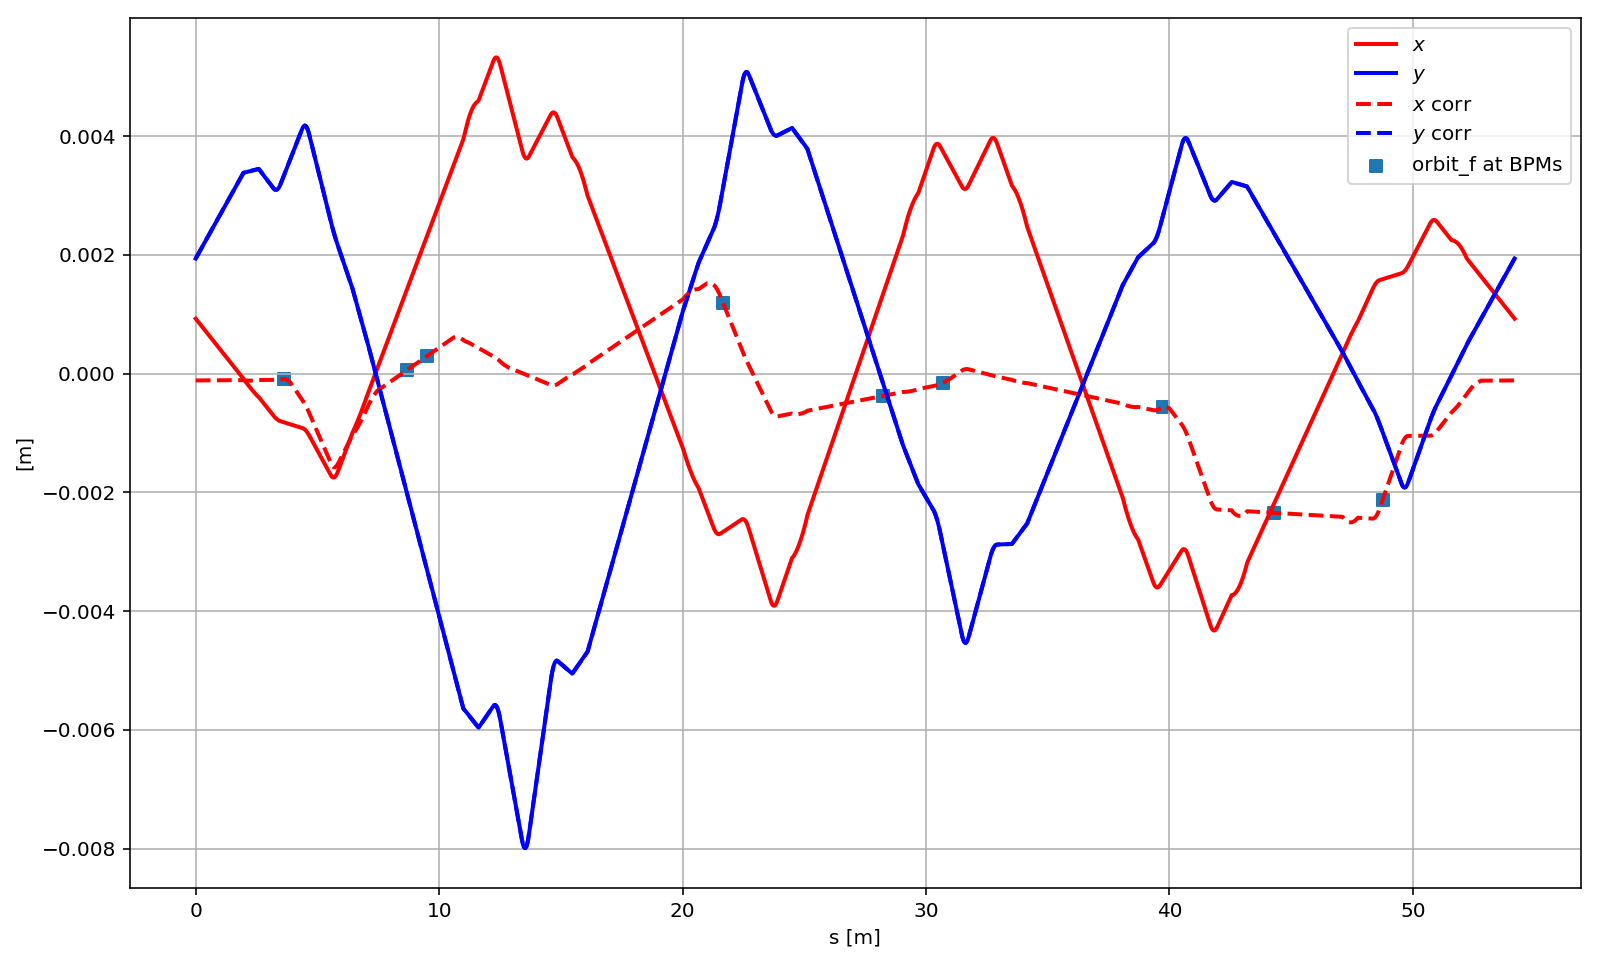

In [117]:
madx.input('kqfl ={}; kqdl ={}; k02kh = {};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k01kh = {};twiss;'.format(kf0,kd0,*vec.x));
myTwiss=madx.table.twiss.dframe() 
bpmDF = myTwiss[myTwiss["keyword"]=="hmonitor"]

fig = plt.figure(figsize=(13,8))

plt.plot(DF0['s'],DF0['x'],'r', label='$x$', lw=2)
plt.plot(DF0['s'],DF0['y'],'b', label='$y$', lw=2)

plt.plot(myTwiss['s'],myTwiss['x'],'r--', label='$x$ corr', lw=2)
plt.plot(myTwiss['s'],myTwiss['y'],'b--', label='$y$ corr', lw=2)
plt.scatter(bpmDF.s,bpmDF.x, marker = "s", label = "orbit_f at BPMs")

plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()


In [98]:
theta = np.zeros(9)
madx.input('''kqfl ={}; kqdl ={}; 
k02kh = {};k03kh1 ={};k03kh2={};k04kh = {};k06kh = {};k08kh ={};k10kh ={};k01kh ={};k01lb={};
twiss;'''.format(kf0,kd0,*theta));

    
kh = np.linspace(-0.003,0.003,30)
#aux = [find_gradient(th) for th in kh]
aux = []
for th in kh:
    theta = np.zeros(9)
    theta[8]=th
    aux.append(find_gradient(theta))

#aux1=[a[0] for a in aux]
#aux2=np.array([a[1] for a in aux])

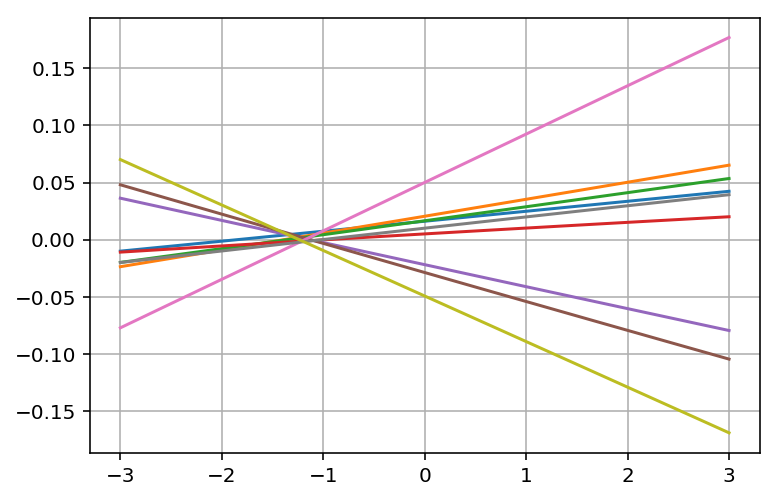

In [99]:
plt.plot(1000*kh,aux)
#plt.plot(1000*kh,100*aux2)

plt.grid(True)